In [1]:
import os
import sys
sys.path.append('/data1/yang_liu/python_workspace/GSPL')

import open3d as o3d
import json
import pickle
import torch
import alphashape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial as spatial
from torch import nn
from tqdm import tqdm
from scipy.spatial import ConvexHull
from plyfile import PlyData, PlyElement
from internal.models.gaussian_model import GaussianModel
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.utils.graphics_utils import fetch_ply
from internal.utils.general_utils import inverse_sigmoid
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Average Distance Analysis & Downsampling & Saving

In [ ]:
import open3d as o3d
file_dir = '../data/GauU_Scene/CUHK_UPPER_COLMAP/cuhksz_upper_campus.ply'
pcd = o3d.io.read_point_cloud(file_dir)
print(len(pcd.points))
print(np.mean(pcd.compute_nearest_neighbor_distance()))
# print(np.std(pcd.compute_nearest_neighbor_distance()))

In [ ]:
ds_pcd = pcd.voxel_down_sample(voxel_size=0.001)
print(np.mean(ds_pcd.compute_nearest_neighbor_distance()))

0.00374213310569026


In [6]:
# save the downsampled point cloud
save_dir = file_dir.replace(".ply", "_ds.ply")
print(save_dir)
o3d.io.write_point_cloud(save_dir, ds_pcd)

True

## 2. Show Spatial Distribution

In [4]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds_35.ply'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transformation.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)

In [5]:
# load model and dataset
model = GaussianModel(sh_degree=3)
model.create_from_pcd(fetch_ply(file_dir), device='cuda')
# model._scaling = nn.Parameter(torch.log(torch.exp(model._scaling) / 100.0))
# model._opacity = nn.Parameter(inverse_sigmoid(torch.ones((model.get_xyz.shape[0], 1), dtype=torch.float, device="cuda")))
renderer = VanillaRenderer()
renderer.setup(stage="val")
renderer = renderer.to("cuda")

print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapDataParser(
    os.path.expanduser("../data/GauU_Scene/LFLS"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapParams(
        split_mode="experiment",
        eval_image_select_mode="ratio",
        eval_ratio=0.1,
        down_sample_factor=3.4175,
    ),
).get_outputs()
print("Test camera count: {}".format(len(dataparser_outputs.test_set.cameras)))

Number of points at initialisation :  31377478
Gaussian count: 31377478
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 958, val set images: 120, loaded mask: 0
Test camera count: 120


In [6]:
model = GaussianModel(sh_degree=3)
model.create_from_pcd(fetch_ply(file_dir), device='cuda')
model._opacity = nn.Parameter(inverse_sigmoid(torch.ones((model.get_xyz.shape[0], 1), dtype=torch.float, device="cuda") * 0.3))

Number of points at initialisation :  31377478


In [7]:
dataset = dataparser_outputs.train_set
bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda")
with torch.no_grad():
    visible_cnt = torch.zeros(model.get_xyz.shape[0], dtype=torch.long, device="cuda")
    for idx in tqdm(range(0, len(dataset.cameras))):
        camera = dataset.cameras[idx].to_device("cuda")
        output = renderer(camera, model, bg_color=bg_color)
        visible_cnt[output['visibility_filter']] += 1

        # plt.style.use('seaborn-v0_8-white')
        # plt.tight_layout()
        # plt.imshow(output["render"].permute(1, 2, 0).cpu().numpy());
        # plt.axis('off')
        # break
        
# plt.hist(visible_cnt.cpu().numpy(), bins=100);

100%|██████████| 958/958 [00:37<00:00, 25.59it/s]


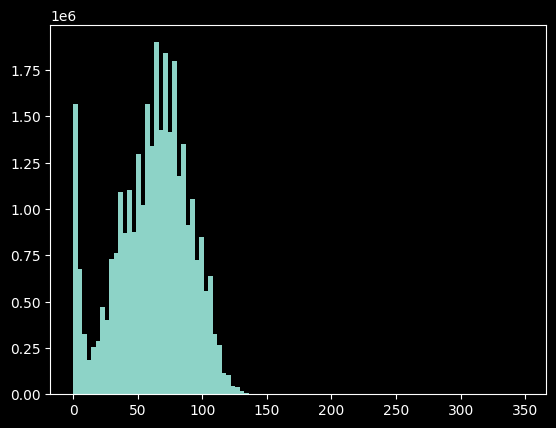

In [9]:
plt.hist(visible_cnt.cpu().numpy(), bins=100);

In [10]:
# MatrixCity
# filtered_pcd = data_np
# color = filtered_pcd[:, 6:9] / 255.0

# GauUScene
filtered_pcd = data_np
xyz_homo = np.concatenate([filtered_pcd[:, :3], np.ones_like(filtered_pcd[:, :1])], axis=-1)
filtered_pcd[:, :3] = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]
color = filtered_pcd[:, 3:6] / 255.0

x_min, x_max = np.min(filtered_pcd[:, 0]), np.max(filtered_pcd[:, 0])
y_min, y_max = np.min(filtered_pcd[:, 1]), np.max(filtered_pcd[:, 1])

In [11]:
mask = visible_cnt.cpu().numpy() > 95  # 95 for lfls, 125 for smbu and matrixcity aerial, 90 for upper, 815 for matrixcity street
hull = alphashape.alphashape(filtered_pcd[mask][::50, :2], alpha=2.0)
# hull = alphashape.alphashape(filtered_pcd[::50, :2], alpha=2.0)
if (hull.geom_type == 'MultiPolygon'):
    # if MultiPolygon, take the smallest convex Polygon containing all the points in the object
    hull = hull.convex_hull
x, y = hull.exterior.xy
x = np.array(x)
y = np.array(y)

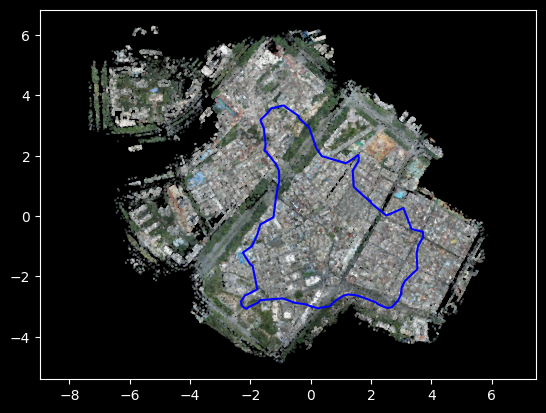

In [12]:
plt.figure()
plt.scatter(filtered_pcd[::100, 0], filtered_pcd[::100, 1], s=0.05, c=color[::100])
# plt.scatter(dataset.cameras.camera_center[:, 0], dataset.cameras.camera_center[:, 1], s=0.1, c='r')
# plt.plot(filtered_pcd[hull_list + [hull_list[0]], 0], filtered_pcd[hull_list + [hull_list[0]], 1], 'r-')
plt.plot(x, y, 'b-')
# plt.grid()
plt.axis('equal')
plt.show()

In [13]:
print(f"Z min: {np.min(filtered_pcd[:, 2])}, Z max: {np.max(filtered_pcd[:, 2])}")
# for idx in hull_list:
#     print(f"[ {filtered_pcd[idx, 0]}, {filtered_pcd[idx, 1]}, 0.0 ],")
for idx in range(len(x)):
    print(f"[ {x[idx]}, {y[idx]}, 0.0 ],")

Z min: 0.5661253333091736, Z max: 2.4628946781158447
[ 2.999495267868042, -2.5818145275115967, 0.0 ],
[ 2.988429069519043, -2.6104896068573, 0.0 ],
[ 2.9822137355804443, -2.6212809085845947, 0.0 ],
[ 2.901324987411499, -2.7951667308807373, 0.0 ],
[ 2.733287811279297, -2.9735567569732666, 0.0 ],
[ 2.7030272483825684, -3.0167629718780518, 0.0 ],
[ 2.6645925045013428, -3.023306369781494, 0.0 ],
[ 2.553490400314331, -3.043531894683838, 0.0 ],
[ 2.5158956050872803, -3.037541389465332, 0.0 ],
[ 2.4984467029571533, -3.032207727432251, 0.0 ],
[ 2.473236322402954, -3.0220954418182373, 0.0 ],
[ 2.402667760848999, -2.9947316646575928, 0.0 ],
[ 2.3241641521453857, -2.960237741470337, 0.0 ],
[ 2.3026645183563232, -2.950711727142334, 0.0 ],
[ 2.242570161819458, -2.925335645675659, 0.0 ],
[ 2.158259630203247, -2.8554487228393555, 0.0 ],
[ 1.8460325002670288, -2.7386109828948975, 0.0 ],
[ 1.521705985069275, -2.6236319541931152, 0.0 ],
[ 1.5033923387527466, -2.622812509536743, 0.0 ],
[ 1.24756968021392

## 3. Compare Point Clouds

In [4]:
import open3d as o3d

pcd_path = '/home/yang_liu/python_workspace/gaussian-opacity-fields/outputs/LFLS/test/ours_60000/fusion/evaluation/pcd.ply'
gt_pcd_path = '../data/GauU_Scene/LFLS/LFLS_ds_30.ply'
# ref_path = "../outputs/citygs_flatten_smbu_coarse/mesh/epoch=60-step=30000/evaluation/pcd.ply"
pcd = o3d.io.read_point_cloud(pcd_path)
gt_pcd = o3d.io.read_point_cloud(gt_pcd_path)
# ref_pcd = o3d.io.read_point_cloud(ref_path)

19683648
41303189


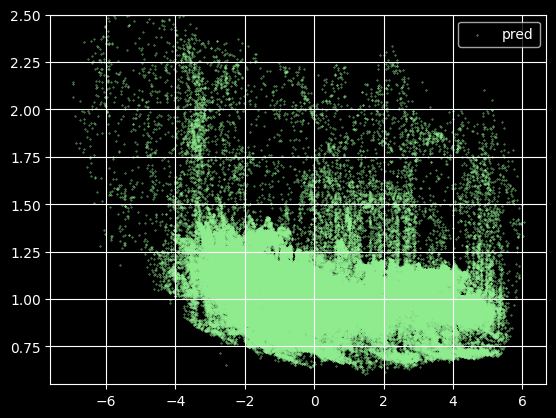

In [9]:
plt.figure()
# print(len(ref_pcd.points))
print(len(pcd.points))
print(len(gt_pcd.points))
# plt.scatter(np.array(ref_pcd.points)[::100, 0], np.array(ref_pcd.points)[::100, 2], s=0.1, label='ref', c='lightblue')
plt.scatter(np.array(pcd.points)[::100, 0], np.array(pcd.points)[::100, 2], s=0.1, label='pred', c='lightgreen')
# plt.scatter(np.array(gt_pcd.points)[::100, 0], np.array(gt_pcd.points)[::100, 2], s=0.05, label='gt', c='red')
# plt.axis('equal')
# plt.xlim(-900, 100)
# plt.ylim(-700, 300)
plt.ylim(0.55, 2.5)
plt.grid()
plt.legend()

## 4. Analyze Checkpoints

In [3]:
file_dir = '../outputs/block_mc_street_block_all_lr_c36_simple_selection_lr2/point_cloud/iteration_60000/point_cloud.ply'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

x_min, x_max = np.min(data_np[:, 0]), np.max(data_np[:, 0])
y_min, y_max = np.min(data_np[:, 1]), np.max(data_np[:, 1])

In [16]:
transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transform.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
xyz_homo = np.concatenate([data_np[:, :3], np.ones_like(data_np[:, :1])], axis=-1)
data_np_pcd = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

In [2]:
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import SH2RGB
# load model and dataset
ckpt_path = '../outputs/citygs2d_rubble_lnorm4_wo_vast_limit/blocks/block_5'
model, renderer = GaussianModelLoader.search_and_load(
    ckpt_path,
    sh_degree=3,
    device="cuda",
)
print(f'Gaussian Count: {model.get_xyz.shape[0]}')
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)

Gaussian Count: 8000094


In [3]:
print(((model.get_scaling[:, :2].min(dim=1)[0] / model.get_scaling[:, :2].max(dim=1)[0]) < 0.01).sum())

tensor(219984, device='cuda:0')


: 

In [8]:
ckpt_path_coarse = '../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast_sep_depth_init_5/checkpoints/epoch=32-step=30000.ckpt'
model_coarse, renderer = GaussianModelLoader.search_and_load(
    ckpt_path_coarse,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
    model_coarse._scaling = torch.cat((torch.ones_like(model_coarse._scaling[:, :1]) * 1e-8, model_coarse._scaling[:, [-2, -1]]), dim=1)

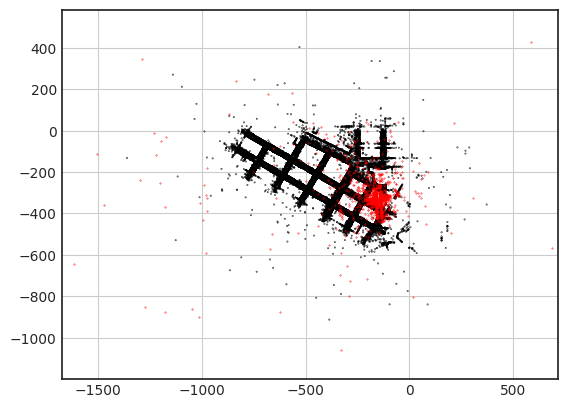

In [21]:
plt.figure()
xyz = model.get_xyz.detach().cpu().numpy()
# xyz_coarse = model_coarse.get_xyz.cpu().numpy()

xyz_homo = np.concatenate([xyz[:, :3], np.ones_like(xyz[:, :1])], axis=-1)
xyz[:, :3] = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

# xyz_coarse_homo = np.concatenate([xyz_coarse[:, :3], np.ones_like(xyz_coarse[:, :1])], axis=-1)
# xyz_coarse[:, :3] = (xyz_coarse_homo @ np.linalg.inv(transform).T)[:, :3]

plt.scatter(filtered_pcd[::100, 0]/100, filtered_pcd[::100, 1]/100, s=0.1, c=filtered_pcd[::100, 3:6] / 255.0)
plt.scatter(-xyz[::100, 0], xyz[::100, 1], s=0.1, c='r')
# plt.scatter(xyz_coarse[::100, 0], xyz_coarse[::100, 2], s=0.1, c='b')
plt.axis('equal')
plt.xlim(-10, 2.5)
plt.ylim(-8, 4)
# plt.ylim(-4, 0)
plt.title(ckpt_path.split('/')[-1])
plt.grid()
plt.show()

Gaussian count of ../data/GauU_Scene/LFLS/LFLS_ds.ply: 3743191
Max ratio: 1.0, Min ratio: 0.0010196679504588246


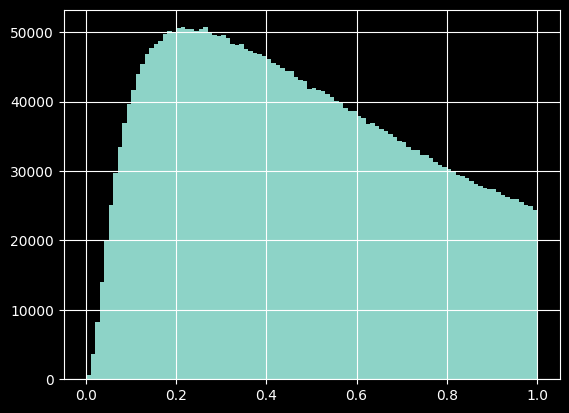

In [81]:
scaling = model.get_scaling
sorted_scaling = scaling.sort(dim=-1)[0]
ratio = sorted_scaling[:, 1] / sorted_scaling[:, 2]
print("Gaussian count of {}: {}".format(file_dir, model.get_xyz.shape[0]))
print(f"Max ratio: {ratio.max().item()}, Min ratio: {ratio.min().item()}")
plt.figure()
plt.hist(ratio.cpu().numpy(), bins=100)
plt.grid()
plt.show()

## 5. Compare Checkpoints' Elongation Distribution

In [22]:
scene='upper'
epoch=95

ckpt_path_coarse1 = f'../outputs/citygs2d_{scene}_coarse_lnorm4_wo_vast_6w/checkpoints/epoch={epoch}-step=60000.ckpt'
model_coarse1, renderer1 = GaussianModelLoader.search_and_load(
    ckpt_path_coarse1,
    sh_degree=3,
    device="cuda",
)
# if isinstance(renderer1, VanillaTrimRenderer):
#     model_coarse1._scaling = torch.cat((torch.ones_like(model_coarse1._scaling[:, :1]) * 1e-8, model_coarse1._scaling[:, [-2, -1]]), dim=1)

ckpt_path_coarse2 = f'../outputs/citygs2d_{scene}_coarse_lnorm4_wo_vast_no_elo_6w/checkpoints/epoch={epoch}-step=60000.ckpt'
model_coarse2, renderer2 = GaussianModelLoader.search_and_load(
    ckpt_path_coarse2,
    sh_degree=3,
    device="cuda",
)
# if isinstance(renderer2, VanillaTrimRenderer):
#     model_coarse2._scaling = torch.cat((torch.ones_like(model_coarse2._scaling[:, :1]) * 1e-8, model_coarse2._scaling[:, [-2, -1]]), dim=1)

Gaussian count of ../outputs/citygs2d_upper_coarse_lnorm4_wo_vast_6w/checkpoints/epoch=95-step=60000.ckpt: 10627233
Extreme Gaussians: 0.0008836731066308606
Gaussian count of ../outputs/citygs2d_upper_coarse_lnorm4_wo_vast_no_elo_6w/checkpoints/epoch=95-step=60000.ckpt: 11048162
Extreme Gaussians: 3.412332295634333e-05


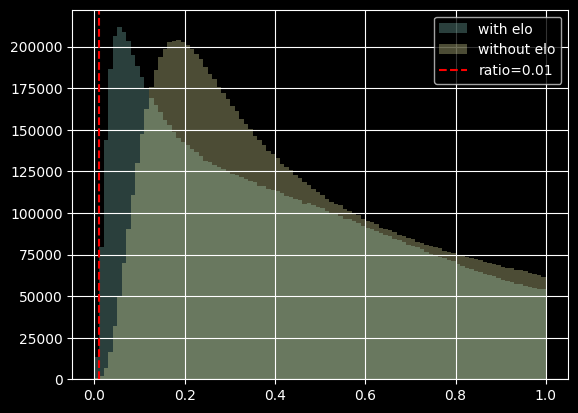

In [23]:
scaling1 = model_coarse1.get_scaling
sorted_scaling1 = scaling1.sort(dim=-1)[0]
ratio1 = sorted_scaling1[:, 1] / sorted_scaling1[:, 2]

scaling2 = model_coarse2.get_scaling
sorted_scaling2 = scaling2.sort(dim=-1)[0]
ratio2 = sorted_scaling2[:, 1] / sorted_scaling2[:, 2]

print("Gaussian count of {}: {}".format(ckpt_path_coarse1, model_coarse1.get_xyz.shape[0]))
print(f"Extreme Gaussians: {ratio1[ratio1 < 0.01].shape[0] / ratio1.shape[0]}")
print("Gaussian count of {}: {}".format(ckpt_path_coarse2, model_coarse2.get_xyz.shape[0]))
print(f"Extreme Gaussians: {ratio2[ratio2 < 0.01].shape[0] / ratio2.shape[0]}")
plt.figure()
plt.hist(ratio1.cpu().numpy(), bins=100, label='with elo', alpha=0.3)
plt.hist(ratio2.cpu().numpy(), bins=100, label='without elo', alpha=0.3)
# plot ratio=0.01
plt.axvline(x=0.01, color='r', linestyle='--', label='ratio=0.01')
plt.legend()
plt.grid()
plt.show()